In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [3]:
df = pd.read_csv('rbc.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns=["TD Close", "CAD Close", "TSX Close", "Low"])
df

,High,Vix Close,RBC Close
Date,,,
2010-01-04,36.403172,20.040001,36.403172
2010-01-05,36.634629,19.350000,35.843815
2010-01-06,35.805235,19.160000,35.580208
2010-01-07,35.695945,19.059999,35.612362
2010-01-08,35.728083,18.129999,35.548061
...,...,...,...
2020-12-23,104.889999,23.309999,104.860001
2020-12-24,105.010002,21.530001,104.910004
2020-12-29,105.680000,23.080000,105.199997


In [4]:
df_input = df
df_output = df[["RBC Close"]]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(df_input, df_output, test_size=0.3, random_state=42, shuffle= False)

In [6]:
x_train.shape

(1894, 3)

In [7]:
x_test.shape

(812, 3)

In [8]:
x_test

,High,Vix Close,RBC Close
Date,,,
2017-09-14,80.403829,10.440000,80.125435
2017-09-15,80.229825,10.170000,80.012329
2017-09-18,80.299427,10.150000,80.186325
2017-09-19,81.117197,10.180000,80.891006
2017-09-20,81.595710,9.780000,81.508713
...,...,...,...
2020-12-23,104.889999,23.309999,104.860001
2020-12-24,105.010002,21.530001,104.910004
2020-12-29,105.680000,23.080000,105.199997


In [9]:
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()

y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

x_train_scaler.fit(x_train)
x_test_scaler.fit(x_test)

y_train_scaler.fit(y_train)
y_test_scaler.fit(y_test)

x_train = x_train_scaler.transform(x_train)
x_test = x_test_scaler.transform(x_test)

y_train = y_train_scaler.transform(y_train)
y_test = y_test_scaler.transform(y_test)


In [10]:
length = 1
batch = 44
features = x_test.shape[1]

train_generator = TimeseriesGenerator(x_train, y_train, length=length, sampling_rate=1, batch_size=batch)
test_generator = TimeseriesGenerator(x_test, y_test, length=length, sampling_rate=1, batch_size=batch)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 

In [12]:
model = Sequential()
units = 64
drop = 0.2

#1st layer
model.add(LSTM(units=units, return_sequences=True, input_shape=(length, features)))
model.add(Dropout(drop))

#2nd layer
model.add(LSTM(units=units, return_sequences=True))
model.add(Dropout(drop))

#3rd layer
model.add(LSTM(units=units))
model.add(Dropout(drop))

# Output layer
model.add(Dense(1))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             17408     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 64)             33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [14]:
class ThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(ThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_loss = logs["val_loss"]
        if val_loss < self.threshold:
            self.model.stop_training = True

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')

earlystop = ThresholdCallback(threshold=0.0011)

model.compile(optimizer="adam", loss="mean_squared_error")


fit = model.fit_generator(train_generator, epochs = 250, validation_data=test_generator, callbacks=[earlystop],
                         shuffle=False)

Epoch 1/250
44/44 [==============================] - 3s 73ms/step - loss: 9.3412e-04 - val_loss: 0.0022
Epoch 2/250
44/44 [==============================] - 3s 66ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 3/250
44/44 [==============================] - 3s 65ms/step - loss: 0.0011 - val_loss: 0.0036
Epoch 4/250
44/44 [==============================] - 3s 75ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 5/250
44/44 [==============================] - 3s 59ms/step - loss: 0.0018 - val_loss: 0.0018
Epoch 6/250
44/44 [==============================] - 3s 60ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 7/250
44/44 [==============================] - 3s 65ms/step - loss: 0.0018 - val_loss: 0.0046
Epoch 8/250
44/44 [==============================] - 3s 66ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 9/250
44/44 [==============================] - 3s 77ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 10/250
44/44 [==============================] - 3s 62ms/step - loss: 0.0024 - val_loss: 0.

In [28]:
model.evaluate_generator(test_generator, verbose=0)

0.001058308424513885

In [29]:
predictions = model.predict_generator(test_generator)

In [30]:
predicted_prices = y_test_scaler.inverse_transform(predictions)
real_prices = y_test_scaler.inverse_transform(y_test[1:].reshape(-1,1))

In [31]:
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks

,Real,Predicted
Date,,
2017-09-15,80.012329,80.821877
2017-09-18,80.186325,80.709389
2017-09-19,80.891006,80.807808
2017-09-20,81.508713,81.450859
2017-09-21,81.978500,81.927368
...,...,...
2020-12-23,104.860001,104.008293
2020-12-24,104.910004,105.026772
2020-12-29,105.199997,105.079605


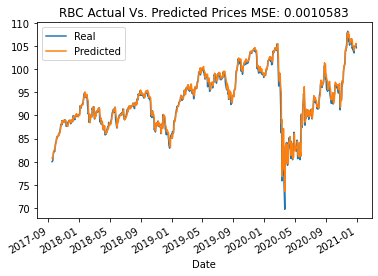

In [32]:
stocks.plot(title=f"RBC Actual Vs. Predicted Prices MSE: 0.0010583")
plt.savefig('RBCDay.png')

In [21]:
stocks["diff"] = stocks["Real"] - stocks["Predicted"]
stocks["diff"].mean()

0.7503247619704165

In [22]:
model_json = model.to_json()
file_path = Path("rbc_model_2.json")
with open(file_path, "w") as json_file:
    json_file.write(model_json)